# **Khởi tạo**

**Import thư viện**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

**Xử lý dữ liệu**

In [6]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Tiền xử lý các cột khác nếu cần thiết

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)

    return data

**Xây dựng mô hình**

In [7]:
def build_and_evaluate_model(file_name, train_ratio=0.7, test_ratio=0.3):
    # Đọc dữ liệu từ file CSV
    df = read_file(file_name)
    df1 = df.reset_index()['Price']
    # Scaler data
    scaler = MinMaxScaler(feature_range=(0,1))
    df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
    # Chia train, test
    train_size = int(train_ratio * len(df1))
    test_size = int(test_ratio * len(df1))
    train_data = df1[:train_size]
    test_data = df1[train_size:train_size+test_size]
    # Hàm Create Dataset
    def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    # Define LSTM Model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)
    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    # Đánh giá độ chính xác thuật toán bằng RMSE
    train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Train RMSE:', train_rmse)
    print('Testing RMSE:', test_rmse)
    def forecast_days(forecast_days):
    # Dự báo n ngày tiếp theo
        x_input = test_data[-time_step:].reshape(1, -1)
        temp_input = list(x_input[0])
        lst_output = []

        while len(lst_output) < forecast_days:
            if len(temp_input) > time_step:
                x_input = np.array(temp_input[1:])
                x_input = x_input.reshape(1, -1)
                x_input = x_input.reshape((1, time_step, 1))
                yhat = model.predict(x_input, verbose=0)
                temp_input.extend(yhat[0].tolist())
                temp_input = temp_input[1:]
                lst_output.extend(yhat.tolist())
            else:
                x_input = x_input.reshape((1, time_step, 1))
                yhat = model.predict(x_input, verbose=0)
                temp_input.extend(yhat[0].tolist())
                lst_output.extend(yhat.tolist())
        return lst_output

    # Dự báo 30, 60, 90 ngày
    forecast_30 = forecast_days(30)
    forecast_60 = forecast_days(60)
    forecast_90 = forecast_days(90)

    # Vẽ hình
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data), label='Train')
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, y_pred, label='Predict')
    # Vẽ dự đoán 30, 60, 90 ngày với các màu khác nhau
    forecast_30_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
    plt.plot(forecast_30_index, scaler.inverse_transform(forecast_30), label='Forecast 30 days')

    forecast_60_index = pd.RangeIndex(start=len(df1), stop=len(df1)+60, step=1)
    plt.plot(forecast_60_index, scaler.inverse_transform(forecast_60), label='Forecast 60 days')

    forecast_90_index = pd.RangeIndex(start=len(df1), stop=len(df1)+90, step=1)
    plt.plot(forecast_90_index, scaler.inverse_transform(forecast_90), label='Forecast 90 days')

    plt.legend()
    plt.show()

# **BIDV**

**BIDV 7:3**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0905 
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 16/100
16

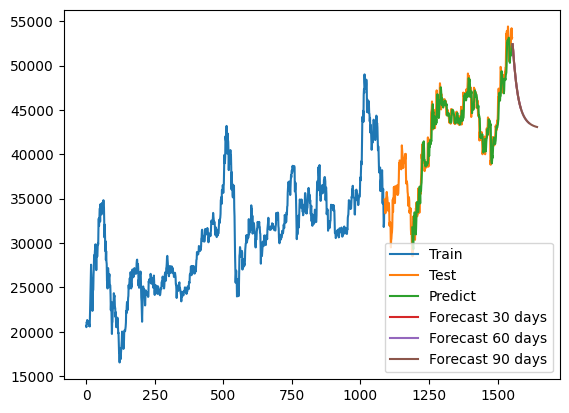

In [8]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3)

**BIDV 8:2**

c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0861 
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8234e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6979e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.

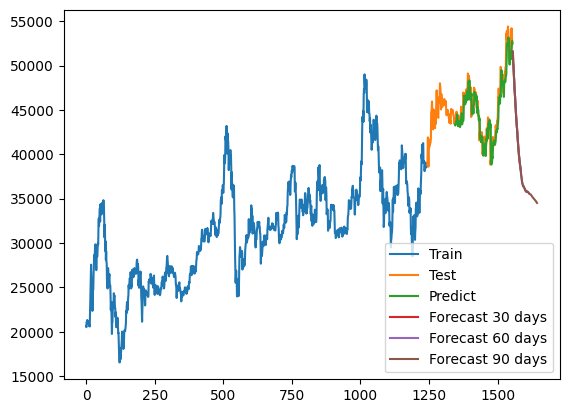

In [9]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2)

**BIDV 9:1**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1725
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0170
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 16/100
21

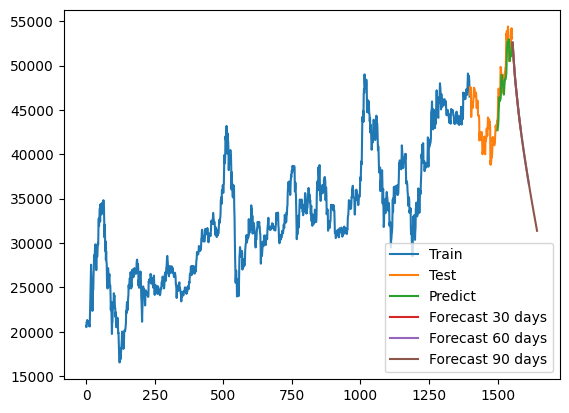

In [10]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1)

# **MBB**

**MBB 7:3**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0576
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010    
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2481e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.8310e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6581e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.8899e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2236e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3284e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1824e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1328e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8822e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

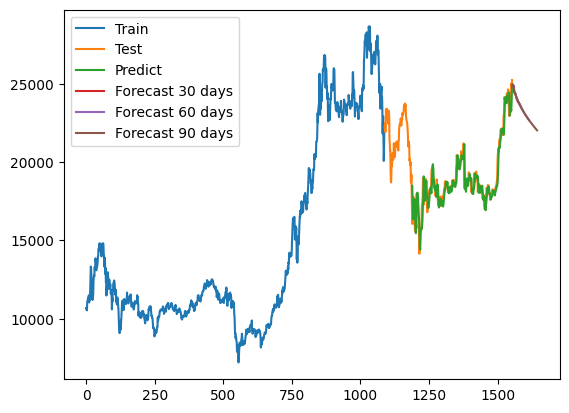

In [11]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3)

**MBB 8:2**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4504
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0022
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019
Epoch 1

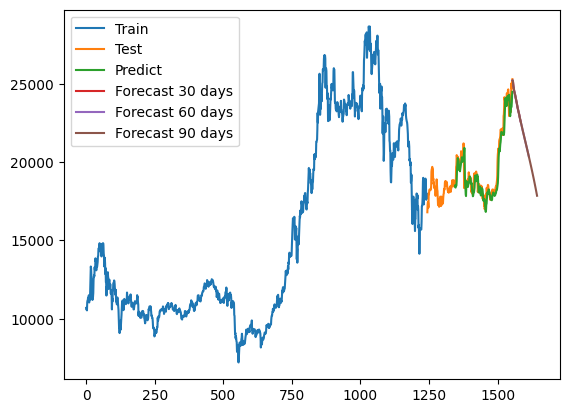

In [12]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2)

**MBB 9:1**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3160
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.9694e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0085e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0276e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6007e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.3857e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0316e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7254e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.5890e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0349e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2193e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━

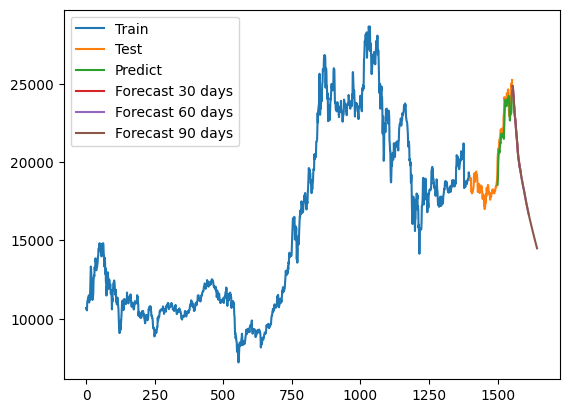

In [13]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1)

# **VCB**

**VCB 7:3**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1205  
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0912e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1510e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7508e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9963e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4932e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7633e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

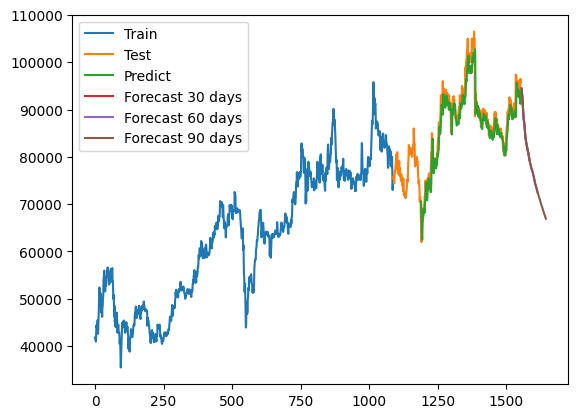

In [14]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3)

**VCB 8:2**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0120 
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3568e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8345e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8548e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0292e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7425e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3362e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.2954e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5714e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4882e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7819e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━

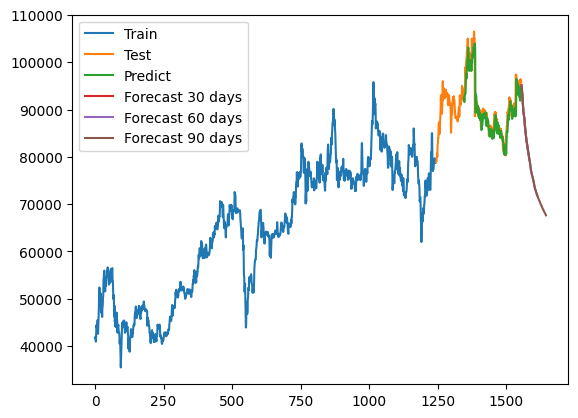

In [15]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2)

**VCB 9:1**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0899 
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012   
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9264e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1213e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6455e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3162e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5667e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1550e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8780e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0951e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

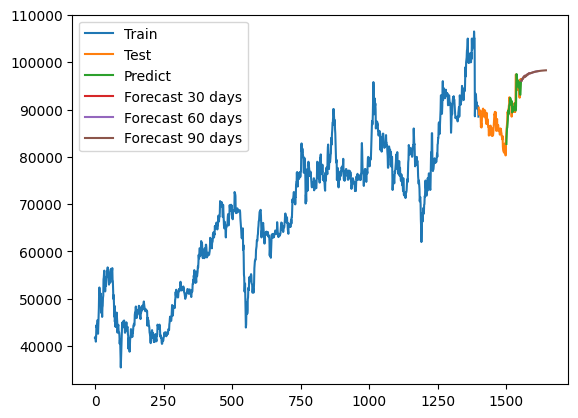

In [18]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1)